An adversary can leverage a dataset reconstruction attack that takes advantage of query answers on a sequestered dataset to reconstruct the data of every individual in the dataset.


This notebook makes use of the Public Use Microdata Sample (PUMS), obtained from the Census Bureau’s American Community Survey (ACS).
Attacks like the one demonstrated in this notebook motivate the use of statistical disclosure limitation techniques like differential privacy.

We will be attempting to determine if each individual in the PUMS sample is a US citizen.

In [2]:
import numpy as np
import pandas as pd

# a dataframe containing the data to be attacked
data: pd.DataFrame = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5reconstruction.csv")

# names of public identifier columns
pub = ["sex", "age", "educ", "latino", "black", "asian",
       "married", "divorced", "children", "disability",
       "militaryservice", "employed", "englishability"]

# variable to reconstruct
target = "uscitizen"

Lets assume that analysts have access to a query interface that returns the number of citizens that satisfy a predicate.
This function first creates a mask matrix of shape `(n, len(predicates))` by evaluating the predicates on the data.
All `len(predicates)` subset sums are computed simultaneously via a matrix product between the target column and mask.

In [3]:
def execute_subsetsums_exact(predicates) -> np.ndarray:
    """Count the number of citizens that satisfy each predicate.
    Resembles a public query interface on a sequestered dataset.

    :param predicates: a list of predicates on the public variables
    :returns a 1-d np.ndarray of exact answers to the subset sum queries"""
    return data[target].values @ np.stack([pred(data) for pred in predicates], axis=1)

Here's a quick example of how an analyst might use this query interface:

In [4]:
execute_subsetsums_exact([
    lambda data: data['sex'] == 1,      # "is-female" predicate
    lambda data: data['married'] == 1,  # "is-married" predicate
])

array([22, 19])

### Reconstruction Attack

An attacker wants to reconstruct the `uscitizen` column in the sequestered dataset.

If we consider the predicate mask `A`, the US citizen column `x`, and the subset sum answers `b`, 
then what we need to do is find the `x` that minimizes `|Ax - b|^2`.
The target column is equivalent to the least squares solution (assuming the public variables uniquely identify each individual).

In [5]:
from scipy.optimize import lsq_linear

def reconstruction_attack(data_pub, predicates, answers):
    """Reconstructs a target column based on the `answers` to queries about `data`.

    :param data_pub: data of length n consisting of public identifiers
    :param predicates: a list of k predicate functions
    :param answers: a list of k answers to a query on data filtered by the k predicates
    :return 1-dimensional boolean ndarray"""
    masks = np.stack([pred(data_pub) for pred in predicates])
    return lsq_linear(masks, answers, bounds=(0, 1)).x > 0.5


We don't want to bother writing a large number of random predicates, 
so we'll make use of a hashing scheme to generate random predicates. 

In [6]:
def make_random_predicate():
    """Returns a (pseudo)random predicate function by hashing public identifiers."""
    prime = 691
    desc = np.random.randint(prime, size=len(pub))
    # this predicate maps data into a 1-d ndarray of booleans
    #   (where `@` is the dot product and `%` modulus)
    return lambda data: ((data[pub].values @ desc) % prime % 2).astype(bool)

# Example usage
random_predicate = make_random_predicate()
num_citizens_that_matched_random_predicate = execute_subsetsums_exact([random_predicate])

# The boolean mask from applying the example predicate to the data:
random_predicate_mask = random_predicate(data)

At this point, we're ready to conduct our attack. 
We generate a large number of random queries, submit them to the query interface, and find the least-squares solution.

In [7]:

predicates = [make_random_predicate() for _ in range(2 * len(data))]
exact_answers = execute_subsetsums_exact(predicates)

# generate example predicates and compute example query answers
reconstructed_target = reconstruction_attack(
    data_pub=data[pub], predicates=predicates, answers=exact_answers)

# complete reconstruction of the target column
assert np.array_equal(reconstructed_target, data[target])

As we can see, the target column is perfectly reconstructed, and the attacker has the US citizenship status of every member of the sequestered dataset.

### Mitigations
What mitigations can the query interface use to prevent this reconstruction?
I've supplied three new query interfaces with mitigations based on rounding, adding gaussian noise, or random sampling.

In [8]:
def execute_subsetsums_round(r, predicates):
    """Return subset sums on the target column, rounded to the nearest multiple of `r`."""
    return (execute_subsetsums_exact(predicates) / r).round() * r


def execute_subsetsums_noise(sigma, predicates):
    """Return subset sums on the target column, with noise ~ gaussian(`sigma`)."""
    return execute_subsetsums_exact(predicates) + np.random.normal(scale=sigma, size=exact_answers.shape)


def execute_subsetsums_sample(t, predicates):
    sub_data = data.iloc[np.random.choice(np.arange(len(data)), size=t, replace=False)]
    return sub_data[target].values @ np.stack([pred(sub_data) for pred in predicates], axis=1)

We'll also want to evaluate the utility of these new query interfaces.
How accurate is dataset reconstruction when these mitigations are in place, and what is the RMSE of the subset sum queries?

In [9]:
def compute_accuracy_reconstruction(reconstructed):
    return (reconstructed == data[target]).mean()


def compute_rmse_answers(answers):
    return np.sqrt(np.mean((answers - exact_answers) ** 2))

interfaces = {
    "round": execute_subsetsums_round,
    "noise": execute_subsetsums_noise,
    "sample": execute_subsetsums_sample
}


def evaluate_performance(interface_name, param):
    predicates_temp = [make_random_predicate() for _ in range(2 * len(data))]
    answers = interfaces[interface_name](param, predicates_temp)
    reconstruction = reconstruction_attack(data[pub], predicates_temp, answers)
    return {
        "interface": interface_name,
        "param": param,
        "answer rmse": compute_rmse_answers(answers),
        "reconstruction accuracy": compute_accuracy_reconstruction(reconstruction),
    }

I've provided a few spot examples of how these mitigations perform.

In [10]:
perf = evaluate_performance("noise", param=2.)
print(f'When noising answers with gaussian sigma of {perf["param"]}, '
        f'RMSE of answers is {perf["answer rmse"]:.4}, and '
        f'{perf["reconstruction accuracy"]:.2%} of entries were reconstructed.')

perf = evaluate_performance("sample", param=10)
print(f'When sampling to {perf["param"]} rows and then correcting for bias, '
        f'RMSE of answers is {perf["answer rmse"]:.4}, and '
        f'{perf["reconstruction accuracy"]:.2%} of entries were reconstructed.')

perf = evaluate_performance("round", param=20)
print(f'When rounding answers to the nearest multiple of {perf["param"]}, '
        f'RMSE of answers is {perf["answer rmse"]:.4}, and '
        f'{perf["reconstruction accuracy"]:.2%} of entries were reconstructed.')
        
perf = evaluate_performance("round", param=40)
print(f'When rounding answers to the nearest multiple of {perf["param"]}, '
        f'RMSE of answers is {perf["answer rmse"]:.4}, and '
        f'{perf["reconstruction accuracy"]:.2%} of entries were reconstructed.')

When noising answers with gaussian sigma of 2.0, RMSE of answers is 4.5, and 99.00% of entries were reconstructed.
When sampling to 10 rows and then correcting for bias, RMSE of answers is 19.49, and 61.00% of entries were reconstructed.
When rounding answers to the nearest multiple of 20, RMSE of answers is 2.894, and 51.00% of entries were reconstructed.
When rounding answers to the nearest multiple of 40, RMSE of answers is 20.11, and 82.00% of entries were reconstructed.


Notice among the last two examples that, as expected, the RMSE of the rounding mitigation increases as the rounding parameter increases.
However, surprisingly, the reconstruction accuracy is greater when the rounding parameter is 40 compared to when it is 20.

The explanation for this is that the average of the exact sums is ~20.39, so when the rounding parameter is 20, nearly all answers returned by the query interface are 20.
Contrast to when the rounding parameter is 40, approximately half of the query answers are 40, and half are 0, giving one bit of entropy per predicate to reconstruct the dataset. 

### Simulations
All mitigations naturally take a parameter ranging between 1 and 100, so lets evaluate the reconstruction accuracy and answer RMSE as this parameter is varied.

In [11]:
def evaluate_all_performances(num_trials=10):
    losses = []
    for interface_name in interfaces:
        print("Evaluating", interface_name)
        for param in range(1, len(data) + 1, 5):
            for _ in range(num_trials):
                losses.append(evaluate_performance(interface_name, param))
    return pd.DataFrame(losses)


all_perf = evaluate_all_performances().groupby(["interface", "param"]).mean()

Evaluating round
Evaluating noise
Evaluating sample


We'll first visualize the reconstruction performance as we vary the parameter supplied to the mitigation.

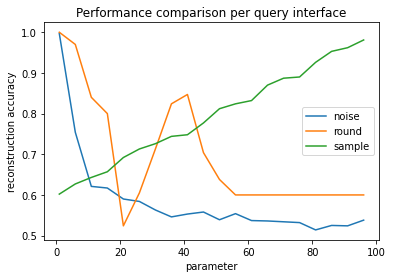

In [12]:
import matplotlib.pyplot as plt

for name, perf in all_perf.groupby("interface"):
    perf.reset_index(inplace=True)
    plt.plot(perf['param'], perf['reconstruction accuracy'], label=name)

plt.legend()
plt.title("Performance comparison per query interface")
plt.xlabel("parameter")
plt.ylabel("reconstruction accuracy")

plt.show()

Since the PUMS sample was stratified to have a 60-40 split, the reconstruction accuracy is still 60% if the reconstructed column consists of all zeros. 
We'll consider 60% our baseline.
Releasing a constant column is the behavior of the sample mitigation when the sample size is ~1, 
or when rounding to the nearest multiple of 60 or more, which rounds all answers to zero.

When using the rounding defense, the greatest amount of information is lost when the mean answer is a multiple of the rounding parameter. 
This effect is most pronounced when the rounding parameter is equal to the mean, at approximately 20. 

Increasing the noise scale very quickly affects the reconstruction accuracy. 
At large noise scales (>10), the noise dominates the signal, leading to a reconstruction accuracy that is worse than the baseline.

The next plot compares the reconstruction accuracy against the RMSE of the answers.

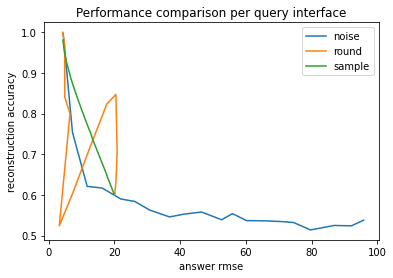

In [13]:
for name, perf in all_perf.groupby("interface"):
    plt.plot(perf['answer rmse'], perf['reconstruction accuracy'], label=name)

plt.legend()
plt.title("Performance comparison per query interface")
plt.xlabel("answer rmse")
plt.ylabel("reconstruction accuracy")

plt.show()

On first impression, the rounding mitigation may look wrong, but we can see how RMSE doesn't drop as we increase dataset size.